<a href="https://colab.research.google.com/github/Alepescinaa/ScientificTools/blob/main/CompressedSensingEx1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises: compressed sensing

In this exercise we will employ compressed sensing for the reconstruction of a high-dimensional signal from a sparse set of random measurements.

Date: 2024

Course: 056936 - SCIENTIFIC COMPUTING TOOLS FOR ADVANCED MATHEMATICAL MODELLING (PAGANI STEFANO) [2023-24].

Example adapted from:
[1] Brunton, S. L., & Kutz, J. N. (2022).
Data-driven science and engineering: Machine learning,
dynamical systems, and control. Cambridge University Press.



The goal of this exercise is to adopt compressed sensing for the reconstruction of a high-dimensional signal from a sparse set of random measurements.

Let us consider a signal composed of a two-tone audio signal:

$x(t) = cos(2 \pi  97t) + cos(2 \pi 777t).$

Note that this signal is sparse in the frequency domain: it is defined by a sum of exactly two cosine waves.

In this exercise, the full signal is generated from $t = 0$ to $t = 1$ with a resolution of $n = 4096$ and is then randomly sampled at $p = 128$ locations in time.
The sparse vector of coefficients in the discrete cosine transform (DCT) basis might be obtained by solving the $\ell = 1$-norm minimization problem using `CVXPY` implementation.

In [22]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
import cvxpy as cvx


Task 1: construct the ground truth vector $\mathbf{u}$ made of 4096 samples of
$u(t) = cos(2 \pi  97t) + cos(2 \pi 777t)$

In [21]:
## Reference signals
n = 4096 # points in high resolution signal
t = np.linspace(0,1,n)
u = np.cos(2 * np.pi * 97 * t) + np.cos(2 * np.pi * 777 * t) # TO DO

# admit a sparse representation
xt = np.fft.fft(u) # Fourier transformed signal
PSD = xt * np.conj(xt) / n # Power spectral density



Task 2: construct a measurement matrix C that randomly sample $\mathbf{u}$ in $128$ points.

In [23]:
## Randomly sample signal
p = 128

perm = np.random.choice(n, p, replace = False)
C = np.zeros((p, n))

for i, idx in enumerate(perm):
  C[i, idx] = 1

y =  C @ u
# C is a matrix of 128 rows


Task 3: write a transformation matrix $\Psi$ made of the discrete cosine transform (DCT) basis, and the matrix $\theta = C \Psi$.

In [24]:
## matrix
Psi = dct(np.identity(n))
Theta =  C @ Psi


Task 4: solve the minimization problem using the CVXPY library

In [25]:
# solving with CVX

# Create vector variables (CVXPY Variable)
s_c = cvx.Variable(shape=np.shape(u))
# Create the constraints (Python list)
constraints = [Theta @ s_c == y]
# Form objective
obj = cvx.Minimize(cvx.norm(s_c, 1))
# Form and solve problem
prob = cvx.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", s_c.value)

urecon = idct(s_c.value)

status: optimal
optimal value 1.6463615390671533
optimal var [ 3.03608124e-13 -6.49790772e-14  1.81665727e-13 ...  3.31616979e-14
  1.55051186e-13  4.20081954e-14]


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


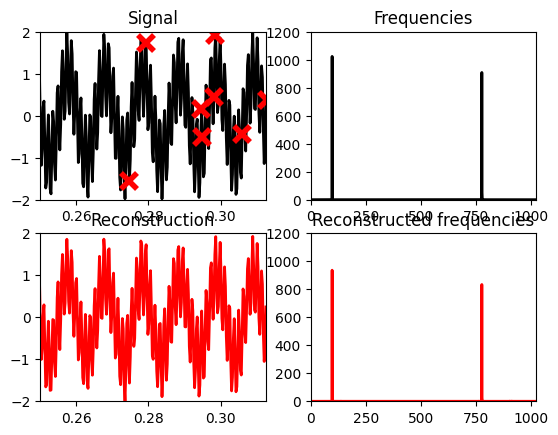

In [26]:
## Visualization
time_window = np.array([1024,1280])/4096
freq = np.arange(n)
L = int(np.floor(n/2))

fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)

axs[1].plot(freq[:L],PSD[:L],color='k',linewidth=2)
axs[1].set_xlim(0, 1024)
axs[1].set_ylim(0, 1200)
axs[1].set_title('Frequencies')

axs[0].plot(t,u,color='k',linewidth=2)
axs[0].plot(perm/n,y,color='r',marker='x',linewidth=0,ms=12,mew=4)
axs[0].set_xlim(time_window[0],time_window[1])
axs[0].set_ylim(-2, 2)
axs[0].set_title('Signal')

axs[2].plot(t,urecon,color='r',linewidth=2)
axs[2].set_xlim(time_window[0],time_window[1])
axs[2].set_ylim(-2, 2)
axs[2].set_title('Reconstruction')

xtrecon = np.fft.fft(urecon,n) # computes the (fast) discrete fourier transform
PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)

axs[3].plot(freq[:L],PSDrecon[:L],color='r',linewidth=2)
axs[3].set_xlim(0, 1024)
axs[3].set_ylim(0, 1200)
axs[3].set_title('Reconstructed frequencies')

plt.show()